In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import tensorflow as tf

import tqdm

from lazy import lazy
from attrdict import AttrDict

from collections import Counter, defaultdict

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
family_classification_metadata = pd.read_table('../seminar_5/data/family_classification_metadata.tab')
family_classification_sequences = pd.read_table('../seminar_5/data/family_classification_sequences.tab')

In [3]:
data = pd.DataFrame({'seq':family_classification_sequences['Sequences'], 'family':family_classification_metadata['FamilyID']})

In [4]:
good_embed = pd.read_csv('good_embed.csv', sep='\t', header=None)
unk_vec = good_embed[good_embed[0] == '<unk>'].iloc[0, 1:101].as_matrix().astype(float)

In [5]:
good_embed_dict = defaultdict(lambda: unk_vec)

In [6]:
for idx, row in good_embed.iterrows():
    good_embed_dict[row[0]] = row[1:101].as_matrix().astype(float)

Task:
Use your ProtVec embedding from homework 5 to perform protein family classification using RNN.
Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable
use 1000 most frequent families for classification
validate your results on the train-test split
reduce the dimensionality of the protein-space using Stochastic Neighbor Embedding and visualize two most frequent classes
compare your RNN results with SVM
visualization and metrics are up to you

In [7]:
MAX_LEN = 600
EMBED_LEN = 100
BATCH_SIZE = 256
NUM_CLASSES = 1000

In [8]:
top_1k_fam = set([f[0] for f in Counter(data['family']).most_common(NUM_CLASSES)])

In [9]:
data_filter = data[data.apply(lambda s: len(s['seq']) < MAX_LEN and s['family'] in top_1k_fam, axis=1)]

In [10]:
data_train, data_test = train_test_split(data_filter, train_size=0.9)

In [11]:
# По идее, тут "переобучаемся" т.к. учитываем все классы, а не только делением на трейн/тест
# вообще надо подумать что делать в таких ситуациях
le = LabelEncoder().fit(data_filter['family'])
oh = OneHotEncoder(n_values=NUM_CLASSES).fit(le.transform(data_filter['family']).reshape(-1,1))

In [12]:


class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, 1000])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar('loss', self.cost)
            tf.summary.scalar('erroe', self.error)
            self.summary = tf.summary.merge_all()
            
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
        return length
    
    @lazy
    def prediction(self):
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                tf.contrib.rnn.GRUCell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(
            tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            optimize = self.params.optimizer.apply_gradients(gradient)
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
        return relevant

In [13]:
params = AttrDict(
    rnn_hidden=256,
    optimizer=tf.train.AdamOptimizer(0.001),
    batch_size=BATCH_SIZE,
    gradient_clipping=100,
    seq_length=MAX_LEN,
    embed_length=EMBED_LEN
)

In [14]:
tf.reset_default_graph()

model = SequenceClassificationModel(params)

/opt/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [15]:
def transform_batch_seq(seqs, batch_size):
    res = np.zeros(shape=(batch_size, MAX_LEN, EMBED_LEN))
    for i, s in enumerate(seqs):
        for j in range(len(s)):
            res[i, j] = good_embed_dict[s[j:j+3]]
    
    return res

def batch_generator(proteins, batch_size):
    while True:
        objs = proteins.sample(n=batch_size)
        
        batch_prots = transform_batch_seq(objs['seq'].as_matrix(), batch_size)
        batch_families = oh.transform(le.transform(objs['family']).reshape(-1,1))
        
        yield batch_prots, batch_families

In [22]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)

iterations = 10000

saver = tf.train.Saver()
save_path = 'checkpoints/rnn'

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('graphs', sess.graph)
    
    accuracy_list = list()
    for index, batch in enumerate(batch_generator(data_train, BATCH_SIZE)):
        train_prots = batch[0]
        train_fam = batch[1].todense()
        
        feed = {model.data: train_prots, model.target: train_fam}
        
        error, _= sess.run([model.error, model.optimize], feed)
        acc = 1 - error
        
        accuracy_list.append(acc)
        
        if index % 10 == 0:
            print('Train accuracy on iteration {}: {:3.1f}%'.format(index + 1, 100 * acc), end='\r')
        if index % 100 == 0:
            saver.save(sess, save_path, index)
        if index == iterations:
            break
            
            test_iter = 50
    
    test_acc = list()
    for index, batch in enumerate(batch_generator(data_test, BATCH_SIZE)):
        train_prots = batch[0]
        train_fam = batch[1].todense()

        feed = {model.data: train_prots, model.target: train_fam}

        error = sess.run(model.error, feed)
        acc = 1 - error

        test_acc.append(acc)

        if index == test_iter:
            break

    print('accuracy on testing: {:3.4f}%'.format(100 * np.mean(test_acc)))

accuracy on testing: 82.9733%0001: 90.2%


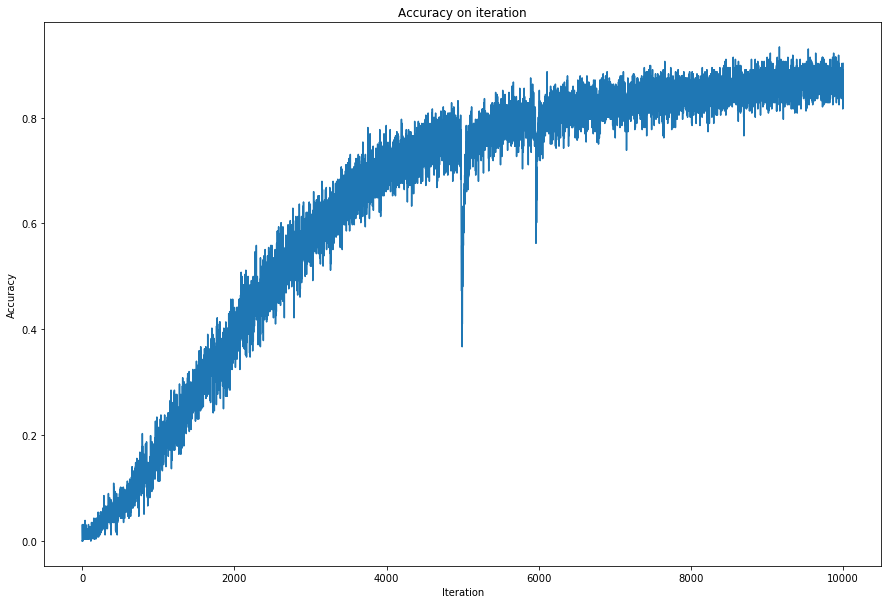

In [23]:
plt.figure(figsize=(15,10))
plt.plot(accuracy_list)

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy on iteration')

In [24]:
def prots_to_vec(seqs, batch_size):
    res = np.zeros(shape=(batch_size, MAX_LEN*EMBED_LEN))
    
    for j, seq in enumerate(seqs):
        for i in range(len(seq)):
            res[j, i*EMBED_LEN:(i+1)*EMBED_LEN] = good_embed_dict[seq[i:i+3]]
    
    return res

def batch_generator_sk(proteins, batch_size):
    while True:
        objs = proteins.sample(n=batch_size)
        
        batch_prots = prots_to_vec(objs['seq'].as_matrix(), batch_size)
        batch_families = le.transform(objs['family'])
        
        yield batch_prots, batch_families

In [25]:
clf = GaussianNB()

nb_iters = 500
classes = np.arange(1000)

for idx, (x_batch, y_batch) in enumerate(tqdm.tqdm_notebook(batch_generator_sk(data_train, BATCH_SIZE), total=nb_iters)):
    clf.partial_fit(x_batch, y_batch, classes=classes)
    
    if idx >= nb_iters:
        break

In [26]:
test_accs = list()

test_iter = 50
for idx, (x_batch, y_batch) in enumerate(tqdm.tqdm_notebook(batch_generator_sk(data_train, BATCH_SIZE), total=test_iter)):
    preds = clf.predict(x_batch)
    
    acc = 1.*sum(preds == y_batch)/y_batch.shape[0]
    test_accs.append(acc)
    
    if idx >= test_iter:
        break

/opt/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:427: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


KeyboardInterrupt: 

In [27]:
print('Accuracy with naive bayes: {}%'.format(100 * np.mean(test_accs)))

Accuracy with naive bayes: 8.85970744680851%


In [33]:
def prots_to_vec_sum(seqs, batch_size):
    res = np.zeros(shape=(batch_size, EMBED_LEN))
    
    for j, seq in enumerate(seqs):
        for i in range(len(seq)):
            res[j] += good_embed_dict[seq[i:i+3]]
        res[j] /= len(seq)
    return res

def batch_generator_sk_sum(proteins, batch_size):
    while True:
        objs = proteins.sample(n=batch_size)
        
        batch_prots = prots_to_vec_sum(objs['seq'].as_matrix(), batch_size)
        batch_families = le.transform(objs['family'])
        
        yield batch_prots, batch_families

In [34]:
clf = GaussianNB()

nb_iters = 1000
classes = np.arange(1000)

for idx, (x_batch, y_batch) in enumerate(tqdm.tqdm_notebook(batch_generator_sk_sum(data_train, BATCH_SIZE), total=nb_iters)):
    clf.partial_fit(x_batch, y_batch, classes=classes)
    
    if idx >= nb_iters:
        break

In [35]:
test_accs = list()

test_iter = 100
for idx, (x_batch, y_batch) in enumerate(tqdm.tqdm_notebook(batch_generator_sk_sum(data_train, BATCH_SIZE), total=test_iter)):
    preds = clf.predict(x_batch)
    
    acc = 1.*sum(preds == y_batch)/y_batch.shape[0]
    test_accs.append(acc)
    
    if idx >= test_iter:
        break

/opt/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:427: RuntimeWarning: divide by zero encountered in log
  jointi = np.log(self.class_prior_[i])


In [36]:
print('Accuracy with naive bayes (sum embeds): {}%'.format(100 * np.mean(test_accs)))

Accuracy with naive bayes (sum embeds): 56.10303217821782%


In [37]:
top_2_fam = set([f[0] for f in Counter(data['family']).most_common(2)])

In [38]:
top_2_fam

{'Helicase_C', 'MMR_HSR1'}

In [47]:
data_viz = data[data.apply(lambda s: len(s['seq']) < MAX_LEN and s['family'] in top_2_fam, axis=1)]
data_viz_vec = prots_вto_vec(data_viz['seq'], data_viz.shape[0])

In [48]:
trans = PCA(n_components=2)
data_viz_pca = trans.fit_transform(data_viz_vec)

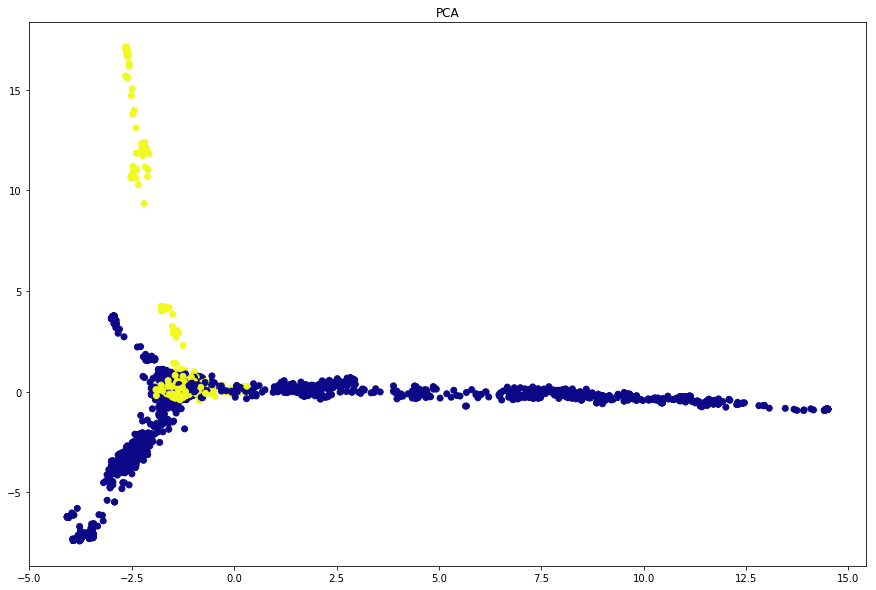

In [49]:
plt.figure(figsize=(15,10))
plt.scatter(data_viz_pca[:,0], data_viz_pca[:,1], c=(data_viz['family'] == 'Helicase_C'), cmap='plasma')
plt.title('PCA')

In [50]:
trans = TSNE(n_components=2, verbose=1)
data_viz_tsne = trans.fit_transform(data_viz_vec)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3708
[t-SNE] Computed conditional probabilities for sample 2000 / 3708
[t-SNE] Computed conditional probabilities for sample 3000 / 3708
[t-SNE] Computed conditional probabilities for sample 3708 / 3708
[t-SNE] Mean sigma: 6.643864
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.235978
[t-SNE] Error after 325 iterations: 1.235978


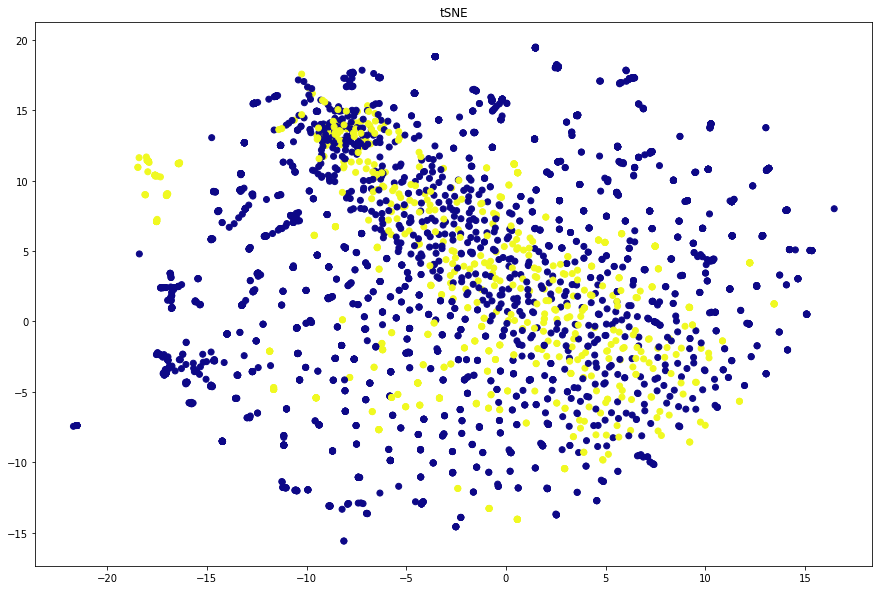

In [51]:
plt.figure(figsize=(15,10))
plt.scatter(data_viz_tsne[:,0], data_viz_tsne[:,1], c=(data_viz['family'] == 'Helicase_C'), cmap='plasma')
plt.title('tSNE')

In [52]:
data_viz = data[data.apply(lambda s: len(s['seq']) < MAX_LEN and s['family'] in top_2_fam, axis=1)]
data_viz_vec = prots_to_vec_sum(data_viz['seq'], data_viz.shape[0])

In [53]:
trans = PCA(n_components=2)
data_viz_pca = trans.fit_transform(data_viz_vec)

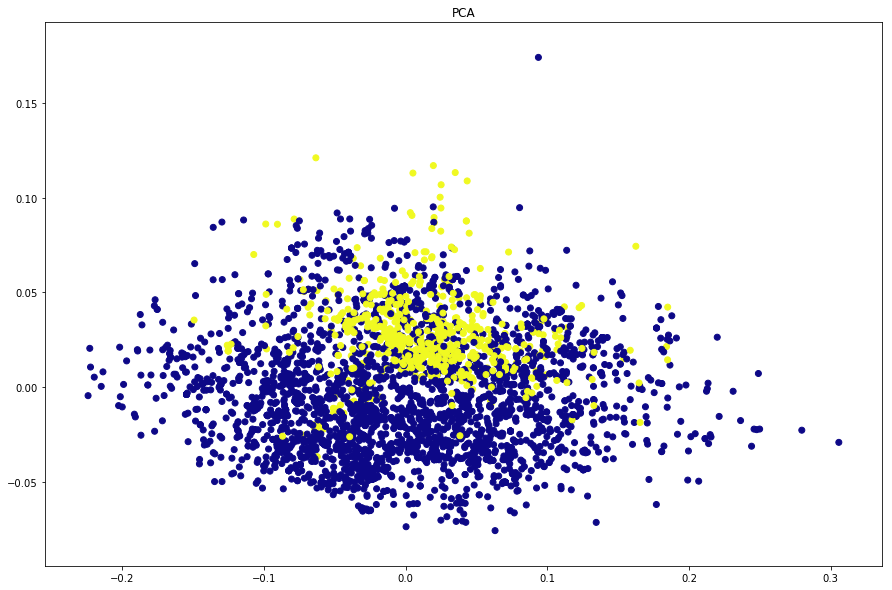

In [54]:
plt.figure(figsize=(15,10))
plt.scatter(data_viz_pca[:,0], data_viz_pca[:,1], c=(data_viz['family'] == 'Helicase_C'), cmap='plasma')
plt.title('PCA')

In [55]:
trans = TSNE(n_components=2, verbose=1)
data_viz_tsne = trans.fit_transform(data_viz_vec)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3708
[t-SNE] Computed conditional probabilities for sample 2000 / 3708
[t-SNE] Computed conditional probabilities for sample 3000 / 3708
[t-SNE] Computed conditional probabilities for sample 3708 / 3708
[t-SNE] Mean sigma: 0.025672
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.279028
[t-SNE] Error after 350 iterations: 1.279028


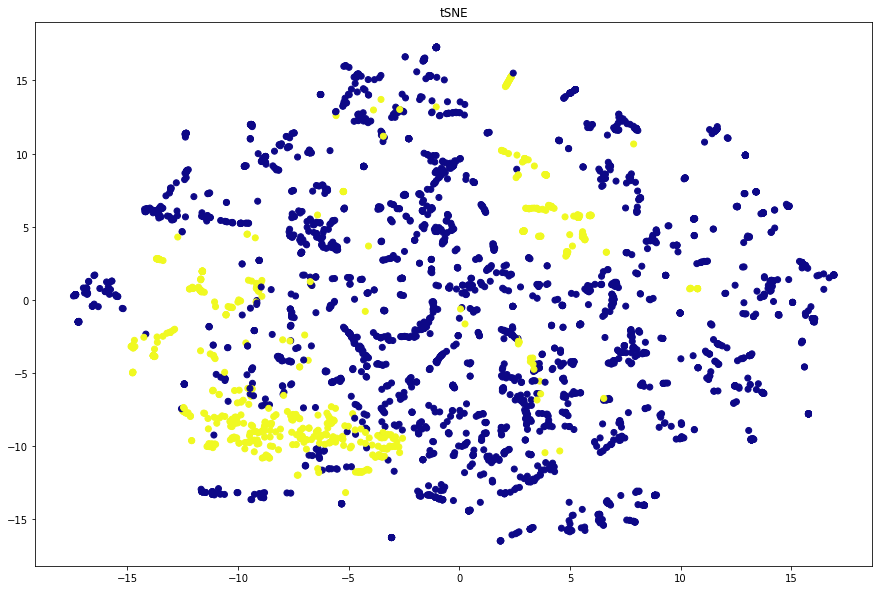

In [56]:
plt.figure(figsize=(15,10))
plt.scatter(data_viz_tsne[:,0], data_viz_tsne[:,1], c=(data_viz['family'] == 'Helicase_C'), cmap='plasma')
plt.title('tSNE')